In [52]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

from tqdm.auto import tqdm

print(torch.__version__)

2.4.0+cu121


## Device agnostic code

In [53]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [54]:
from torchvision.datasets import MNIST

train_dataset = MNIST(root='data',
                      train=True,
                      download=True,
                      transform=ToTensor(),
                      target_transform=None
                      )

test_dataset = MNIST(root='data',
                     train=False,
                      download=True,
                      transform=ToTensor(),
                     )

class_names = train_dataset.classes
len(train_dataset), len(test_dataset), class_names

(60000,
 10000,
 ['0 - zero',
  '1 - one',
  '2 - two',
  '3 - three',
  '4 - four',
  '5 - five',
  '6 - six',
  '7 - seven',
  '8 - eight',
  '9 - nine'])

## Visualize at least 5 different samples of the MNIST training dataset.

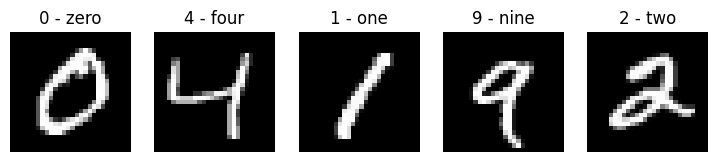

In [55]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows = 1
cols = 5
for i in range(1,6):
  image, label = train_dataset[i]
  fig.add_subplot(rows, cols, i)
  plt.imshow(image.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False);

## 7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [56]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=32,
                              shuffle=True
                              )

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=32,
                             shuffle=False
                             )

len(train_dataloader),len(test_dataloader)

(1875, 313)

## 8. Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [57]:
class MNISTmodel(nn.Module):
  def __init__(self,input_shape, hidden_units, output_shape):
    super().__init__()
    self.block1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
    )
    self.block2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
    )
    self.classifizer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape),
    )

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.classifizer(x)
    return x

torch.manual_seed(42)
model_0 = MNISTmodel(input_shape=1,
                     hidden_units=10,
                     output_shape=len(class_names)).to(device)

model_0

MNISTmodel(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifizer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

## Loss function and optimizer

In [58]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

## Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [59]:
torch.manual_seed(42)

epochs = 5
model_0.to(device)
for epoch in range(epochs):
  train_loss = 0
  for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()

        X = X.to(device)
        y = y.to(device)

        y_pred = model_0(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

  train_loss /= len(train_dataloader)

  test_loss_total = 0

  model_0.eval()

  with torch.inference_mode():
    for batch, (X_test, y_test) in enumerate(test_dataloader):
      X_test = X_test.to(device)
      y_test = y_test.to(device)

      test_pred = model_0(X_test)
      test_loss = loss_fn(test_pred,y_test)

      test_loss_total += test_loss

    test_loss_total /= len(test_dataloader)

  print(f"Epoch: {epoch} | Loss: {train_loss:.3f} | Test loss: {test_loss_total:.3f}")


Epoch: 0 | Loss: 0.332 | Test loss: 0.074
Epoch: 1 | Loss: 0.080 | Test loss: 0.071
Epoch: 2 | Loss: 0.063 | Test loss: 0.052
Epoch: 3 | Loss: 0.054 | Test loss: 0.063
Epoch: 4 | Loss: 0.048 | Test loss: 0.043


## Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

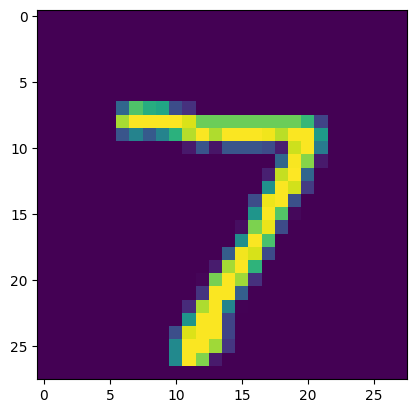

In [60]:
plt.imshow(test_dataset[0][0].squeeze())

In [61]:
model_pred_logits = model_0(test_dataset[0][0].unsqueeze(dim=0).to(device)) # make sure image is right shape + on right device
model_pred_probs = torch.softmax(model_pred_logits, dim=1)
model_pred_label = torch.argmax(model_pred_probs, dim=1)

model_pred_label

tensor([7], device='cuda:0')

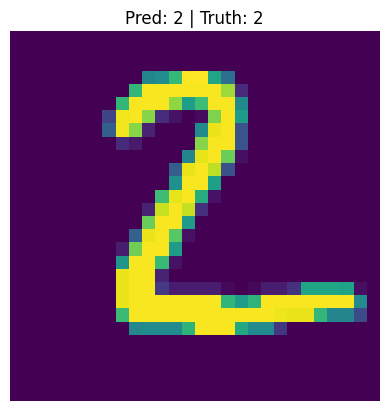

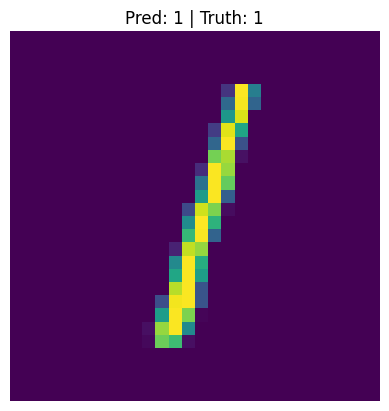

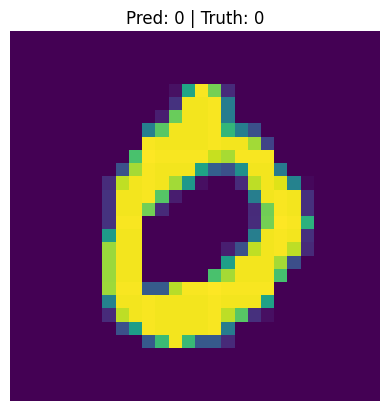

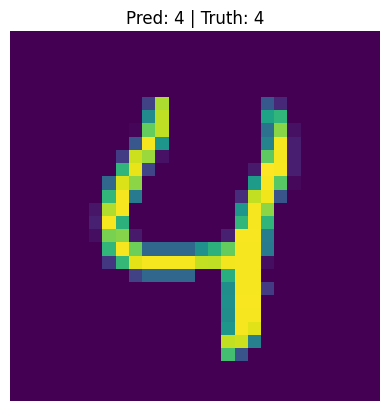

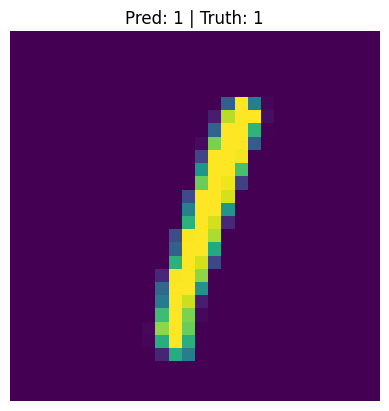

In [62]:
for i in range(1,6):
  img = test_dataset[i][0]
  label = test_dataset[i][1]

  model_pred_logits = model_0(img.unsqueeze(dim=0).to(device))
  model_pred_probs = torch.softmax(model_pred_logits, dim=1)
  model_pred_label = torch.argmax(model_pred_probs, dim=1)

  plt.figure()
  plt.imshow(img.squeeze())
  plt.title(f'Pred: {model_pred_label.cpu().item()} | Truth: {label}')
  plt.axis(False)

## Plot a confusion matrix comparing your model's predictions to the truth labels.

In [63]:
from tqdm.auto import tqdm

y_preds = []

model_0.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    X, y = X.to(device), y.to(device)

    y_logit = model_0(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [64]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.1


In [65]:
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19

0.23.1


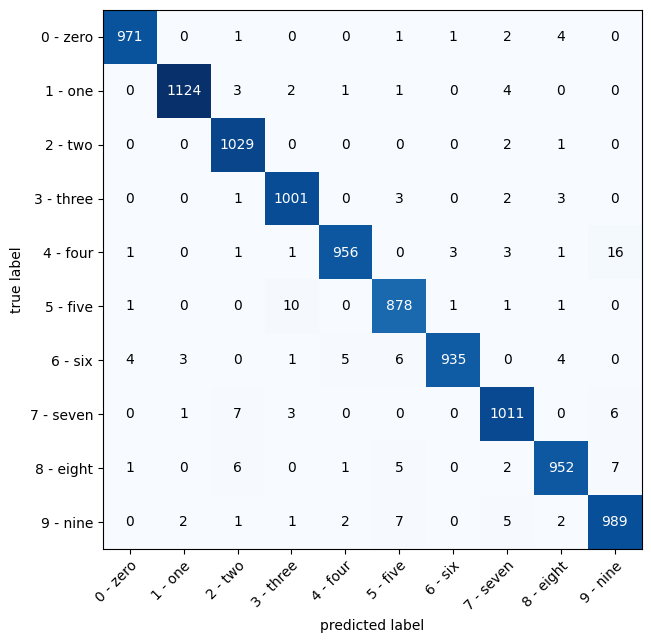

In [66]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_dataset.targets)


fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
);

## Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?

In [67]:

random_tensor = torch.rand([1, 3, 64, 64])
random_tensor.shape

torch.Size([1, 3, 64, 64])

In [68]:
conv2d_layer = nn.Conv2d(in_channels=3,
                         out_channels=64,
                         kernel_size= 3,
                         stride=2,
                         padding=1)

print(f'Random tensor shape: {random_tensor.shape}')
conv2d_tensor = conv2d_layer(random_tensor)
print(f'Conv2d random tensor shape: {conv2d_tensor.shape}')

Random tensor shape: torch.Size([1, 3, 64, 64])
Conv2d random tensor shape: torch.Size([1, 64, 32, 32])


## Use a model similar to the trained `model_2` from notebook 03 to make predictions on the test [`torchvision.datasets.FashionMNIST`](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) dataset.
* Then plot some predictions where the model was wrong alongside what the label of the image should've been.
* After visualing these predictions do you think it's more of a modelling error or a data error?
* As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?

In [69]:
from torchvision import datasets
from torchvision import transforms

fashion_mnist_train = datasets.FashionMNIST(root=".",
                                            download=True,
                                            train=True,
                                            transform=transforms.ToTensor())

fashion_mnist_test = datasets.FashionMNIST(root=".",
                                           train=False,
                                           download=True,
                                           transform=transforms.ToTensor())

len(fashion_mnist_train), len(fashion_mnist_test)

(60000, 10000)

In [70]:
class_names = fashion_mnist_test.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [71]:
from torch.utils.data import DataLoader

fashion_mnist_train_dataloader = DataLoader(dataset=fashion_mnist_train,
                              batch_size=32,
                              shuffle=True
                              )

fashion_mnist_test_dataloader = DataLoader(dataset=fashion_mnist_test,
                             batch_size=32,
                             shuffle=False
                             )

len(fashion_mnist_train_dataloader),len(fashion_mnist_test_dataloader)

(1875, 313)

In [72]:
model_2 = MNISTmodel(input_shape=1,
                      hidden_units=10,
                      output_shape=10).to(device)
model_2

MNISTmodel(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifizer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [73]:
from torch import nn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.01)

In [74]:
from tqdm.auto import tqdm
from torchmetrics import Accuracy

acc_fn = Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)

eposhs = 5
for epoch in tqdm(range(epochs)):
  train_loss, test_total_loss= 0, 0
  train_acc, test_acc = 0, 0

  model_2.train()

  for batch, (X_train, y_train) in enumerate(fashion_mnist_train_dataloader):
    X_train, y_train = X_train.to(device), y_train.to(device)

    y_pred = model_2(X_train)
    loss = loss_fn(y_pred,y_train)
    train_loss += loss
    train_acc += acc_fn(y_pred,y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(fashion_mnist_train_dataloader)
  train_acc /= len(fashion_mnist_train_dataloader)

  model_0.eval()
  with torch.inference_mode():
    for batch, (X_test, y_test) in enumerate(fashion_mnist_test_dataloader):
      X_test, y_test = X_test.to(device), y_test.to(device)

      y_test_pred = model_2(X_test)
      test_loss = loss_fn(y_test_pred, y_test)
      test_total_loss += test_loss

      test_acc += acc_fn(y_test_pred, y_test)

    test_total_loss /= len(fashion_mnist_test_dataloader)
    test_acc /= len(fashion_mnist_test_dataloader)

  print(f"Epoch: {epoch} | Train loss: {train_loss:.3f} | Train acc: {train_acc * 100:.2f}% | Test loss: {test_total_loss:.3f} | Test acc: {test_acc * 100:.2f} %")





  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.300 | Train acc: 52.93% | Test loss: 0.675 | Test acc: 76.23 %
Epoch: 1 | Train loss: 0.566 | Train acc: 79.49% | Test loss: 0.499 | Test acc: 81.99 %
Epoch: 2 | Train loss: 0.454 | Train acc: 83.54% | Test loss: 0.447 | Test acc: 84.42 %
Epoch: 3 | Train loss: 0.413 | Train acc: 85.01% | Test loss: 0.427 | Test acc: 84.76 %
Epoch: 4 | Train loss: 0.384 | Train acc: 86.27% | Test loss: 0.387 | Test acc: 86.27 %


In [75]:
test_preds = []

model_2.eval()
with torch.inference_mode():
  for X_test, y_test in tqdm(fashion_mnist_test_dataloader):
    y_logits = model_2(X_test.to(device))

    y_pred_probs = torch.softmax(y_logits, dim=1)
    y_pred_labels = torch.argmax(y_pred_probs, dim=1)

    test_preds.append(y_pred_labels)

test_preds = torch.cat(test_preds).cpu()
test_preds[:10], len(test_preds)

  0%|          | 0/313 [00:00<?, ?it/s]

(tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7]), 10000)

In [76]:
# Get wrong prediction indexes
import numpy as np
wrong_pred_indexes = np.where(test_preds != fashion_mnist_test.targets)[0]
len(wrong_pred_indexes)

1373

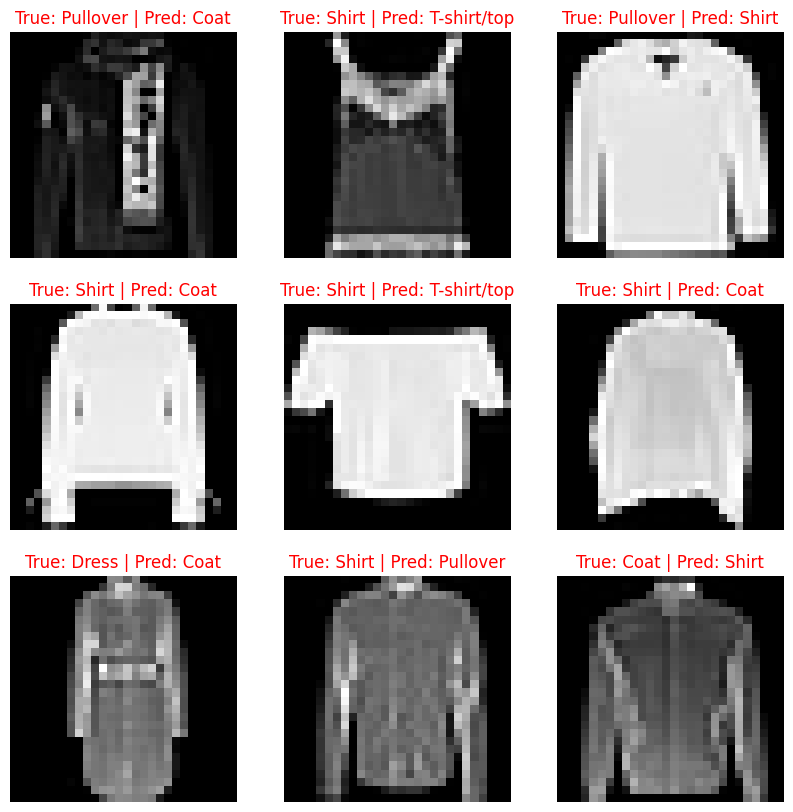

In [77]:
import random
random_selection = random.sample(list(wrong_pred_indexes), k=9)

plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_selection):
  true_label = class_names[fashion_mnist_test[idx][1]]
  pred_label = class_names[test_preds[idx]]

  plt.subplot(3, 3, i+1)
  plt.imshow(fashion_mnist_test[idx][0].squeeze(), cmap="gray")
  plt.title(f"True: {true_label} | Pred: {pred_label}", c="r")
  plt.axis(False);